In [1]:
# 用osmx构建street
# 用API 得到street对应的 meshblock
# 把street转成meshblock
# 根据street的邻居构建 meshblock 的边

In [2]:
import time

import numpy as np
import requests
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((222219.771 -4050395.343, 224043.539 ...  -35.698392  -37.364474   

    bbox_east   bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  175.903215  173.896328  298615087  relation  2094141 -36.541281  174.55061   

            display_name     class            type  importance  
0  Auckland, New Zealand  boundary  administrative        0.66  


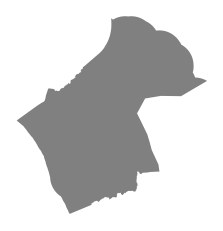

In [3]:
# Find New Market location from osmx package
# city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
# city_proj = ox.project_gdf(city)
# ax = city_proj.plot(fc="gray", ec="none")
# _ = ax.axis("off")
# print(city_proj)

# Find Auckland location from osmx package
city = ox.geocode_to_gdf("Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [4]:
# New Market graph
# highway_G = ox.graph_from_point(
#     (-36.8679152, 174.7774390),
#     dist=500,
#     dist_type="network",
#     network_type="walk",
#     simplify=False,
#     retain_all=True,
#     custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
# )
# print(highway_G)

north, south, east, west = city_proj['bbox_north'][0],city_proj['bbox_south'][0],city_proj['bbox_east'][0],city_proj['bbox_west'][0]

highway_G = ox.graph_from_bbox(north,south,west,east, network_type='walk',
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]')
print(highway_G)

MultiDiGraph with 625077 nodes and 1280700 edges


In [5]:
# turn off strict mode and see what nodes we'd remove, in yellow
#nc = ["r" if ox.simplification._is_endpoint(highway_G, node) else "y" for node in highway_G.nodes()]
#fig, ax = ox.plot_graph(highway_G, node_color=nc)

In [6]:
graph_nodes_df = pd.DataFrame.from_dict(dict(highway_G.nodes(data=True)), orient='index')
#nodes_df.loc[25771299]

In [19]:
def fetch_meshblock_from_api(shared_meshblock_dict, node_list, node_df):
    i=0
    for s in node_list:
        if s in shared_meshblock_dict.keys():
            continue
        source_node = node_df.loc[s]

        # layer seems fixed, may need to change key from STATS NZ every first run
        request = requests.get('https://datafinder.stats.govt.nz/services/query/v1/vector.json/?v=1.2&key=f00b3520ff68464fbe963348c41fcda7&layer=105176&x={x}&y={y}&radius=12&max_results=10&geometry=true&with_field_names=true'.format(x=source_node["x"],y=source_node["y"]))
        #print(request)
        response = request.json()
        #print(response)
        #break
        layers = response['vectorQuery']['layers']
        # GET meshblock Id from API
        meshblock_id = ""
        for layer in layers.values():
            for feature in layer["features"]:
                meshblock_id = feature['properties']['MB2021_V1_00']
                break
            # found meshblock in first layer, stop
            if meshblock_id != "":
                break
        # replace node id to meshblock id
        shared_meshblock_dict[s] = meshblock_id
        i+=1
        if i%1000==0:
            print("Done: ",i)
    return shared_meshblock_dict

In [8]:
def construct_source_and_target_nodes_from_graph(graph_G):
    source_list = []
    target_list = []
    for edge in graph_G.edges(data=True):
        u,v,data = edge
        source_list.append(u)
        target_list.append(v)
    return source_list,target_list

In [9]:
source_nodes_list,target_nodes_list = construct_source_and_target_nodes_from_graph(highway_G)

unique_nodes_list = np.unique(source_nodes_list + target_nodes_list)
unique_nodes_list.sort()
print("Unique source node length: ",len(unique_nodes_list))

Unique source node length:  625074


In [20]:
for i in range(179000,630000,3000):
    #print(len(unique_nodes_list[620000:630000]))
    meshblock_mapping_dict= {}
    meshblock_mapping_dict = fetch_meshblock_from_api(meshblock_mapping_dict,unique_nodes_list[i:i+3000],graph_nodes_df)

    with open("./output/meshblock_mapping{i}.csv".format(i=i), 'w') as f:
        for key, value in meshblock_mapping_dict.items():
            f.write('%s,%s\n' % (key, value))
    time.sleep(20)

Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000
Done:  1000
Done:  2000
Done:  3000


ConnectionError: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))

In [ ]:
def replace_node_id_with_meshblock_id(node_list,mapping_dict):
    # using global dict to check
    mapping_keys = mapping_dict.keys()
    output_list = []
    for node in node_list:
        if node not in mapping_keys:
            output_list.append("-1")
        output_list.append(str(mapping_dict[node]))
    return output_list

In [ ]:
# replace node with meshblock
source_meshblock_list = replace_node_id_with_meshblock_id(source_nodes_list,meshblock_mapping_dict)
target_meshblock_list = replace_node_id_with_meshblock_id(target_nodes_list,meshblock_mapping_dict)

In [ ]:
zipped_meshblock_list = list(zip(source_meshblock_list, target_meshblock_list))
meshblock_edge_df = pd.DataFrame(zipped_meshblock_list,columns=["source","target"])
print(meshblock_edge_df.head(5))

In [ ]:
meshblock_edge_df = meshblock_edge_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
print(meshblock_edge_df.describe())
meshblock_edge_df.to_csv("./output/meshblock_edges.csv",header=False,index=False)